# Introduction and Summary
This document includes data analysis and discussion of the threat UUV modeling and simulation results.  It first compares two versions of the threat UUV sonar and mine detection model.  This provides insight into possible model refinement.  The document then analyzes the datasets in their entirety to identify major interactions and causal relationships between model parameters and output metrics.  This analysis revealed that the two most important considerations relating to mine detection and localization in the model are the **side sensor performance** and the **heading accuracy** of the UUV.  Using the results of this general analysis, models are built corresponding to the output metrics with the goal of providing insight into optimum counter UUV solutions.

# UUV Model Evaluation

Two versions of the UUV model were run in the same scenario.  The version 1 model uses a probabilistic mine detection sonar function.  The version 2 model uses an active sonar model with stochastic noise levels for mine detection.

In [2]:
# load the experiment designs
doe.v1 <- read.csv("./horseshoe_trial/nolh-description.csv", header = TRUE)  
doe.v2 <- read.csv("./version2/v2_pyDOE_lhs_description.csv", header = TRUE)  # LHS experiment
doe.v2.nolh <- read.csv("./version2/v2_NOLH_description.csv", header = TRUE)  # NOLH experiment

# load the results
results.v1 <- read.csv("./horseshoe_trial/horseshoe-trial horseshoe1-table.csv", skip=6, header=TRUE)
results.v2 <- read.csv("./version2/horseshoe-trialv2 horseshoe version 2 lhs run 2-table.csv", skip=6, header = TRUE)
results.v2.nolh <- read.csv("./version2/horseshoe-trialv2 horseshoe version 2 nolh-table.csv", skip=6, header = TRUE)

# rename the index of the experiment design data to simplify merging
colnames(doe.v1)[1] <- "experiment.number"
colnames(doe.v2)[1] <- "experiment.number"
colnames(doe.v2.nolh)[1] <- "experiment.number"

data.v1 <- merge(doe.v1, results.v1, "experiment.number")
data.v2 <- merge(doe.v2, results.v2, "experiment.number")
data.v2.nolh <- merge(doe.v2.nolh, results.v2.nolh, "experiment.number")

# exclude runs that did not finish
filtered.data.v1 <- data.v1[data.v1$X.step!=20000,]
filtered.data.v2 <- data.v2[data.v2$X.step!=35000,]
filtered.data.v2.nolh <- data.v2.nolh[data.v2.nolh$X.step!=35000,]

## Test for difference in the models and experiment designs
Looking at the distribution of the number of mine contacts detected in a random selection of runs for each model version, there is clearly a difference.  Version 2 has a much larger proportion of low detection runs.

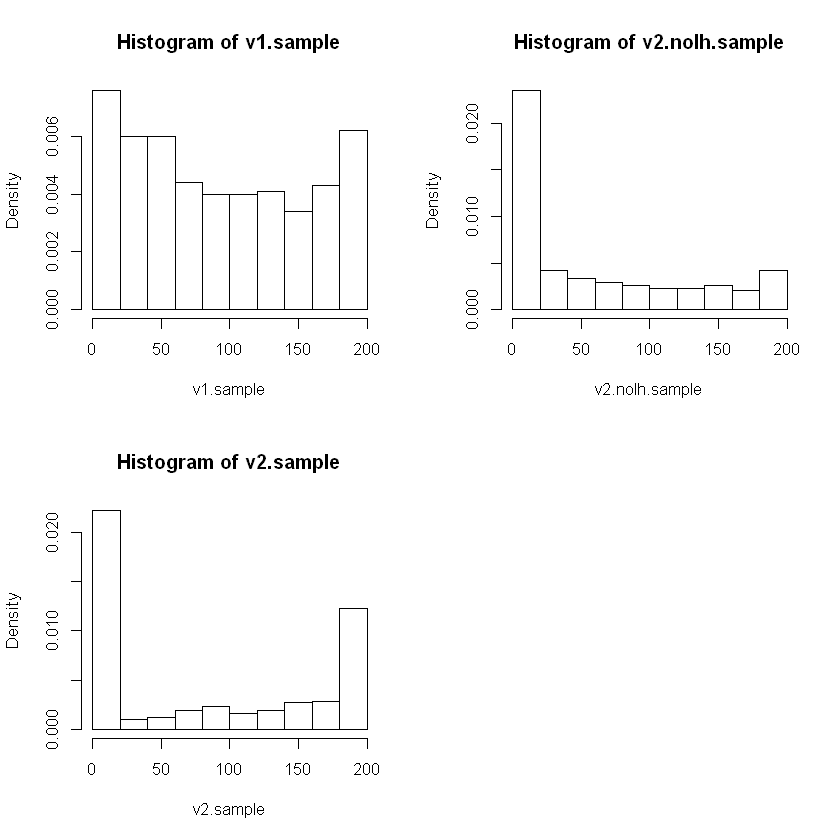

In [3]:
# take 500 samples from the mine contact results
v1.sample <- sample(filtered.data.v1$count.mine.contacts, 500)
v2.sample <- sample(filtered.data.v2$count.mine.contacts, 500)
v2.nolh.sample <- sample(filtered.data.v2.nolh$count.mine.contacts, 500)

layout(matrix(c(1,2,3,4),2,2))
hist(v1.sample, freq=FALSE)
hist(v2.sample, freq=FALSE)
hist(v2.nolh.sample, freq=FALSE)

Why might this be happening?  Let's compare some of the key input values between the runs to see if the experiment design is impacting the result.

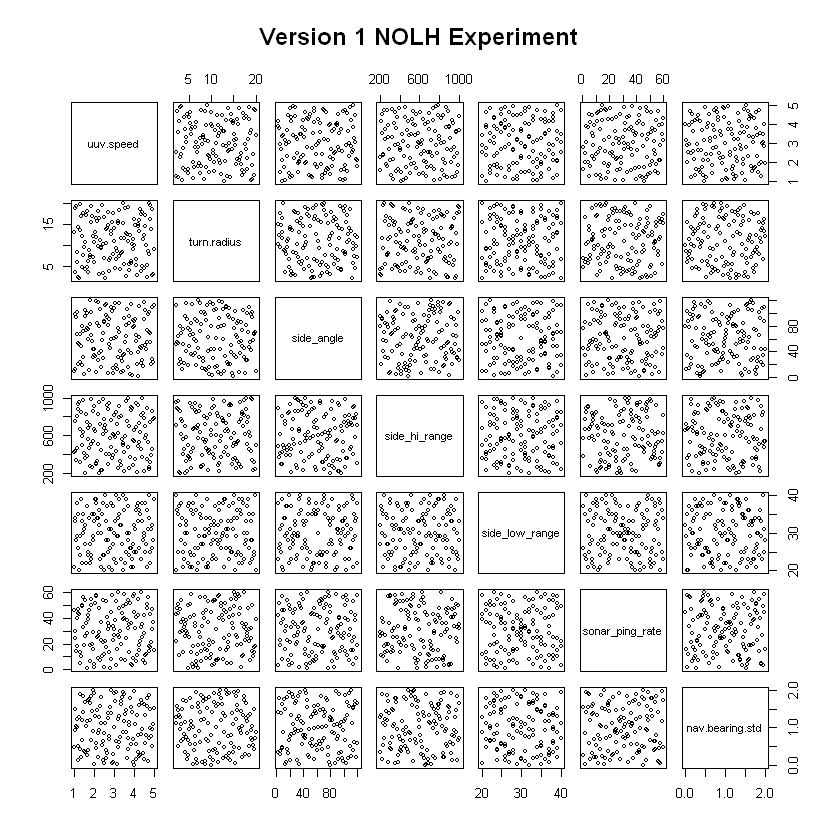

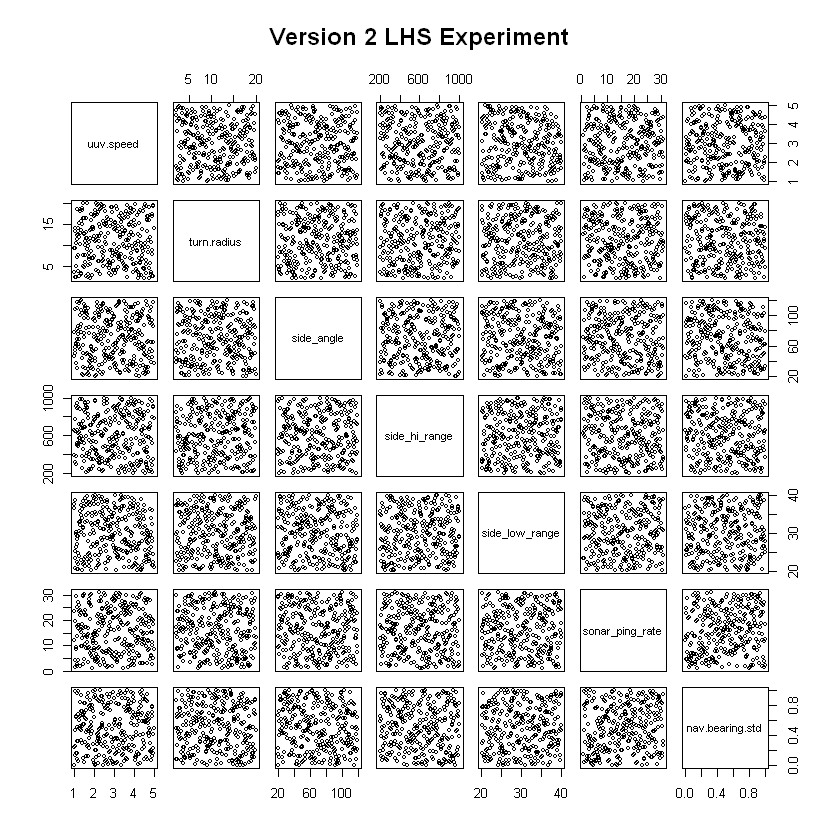

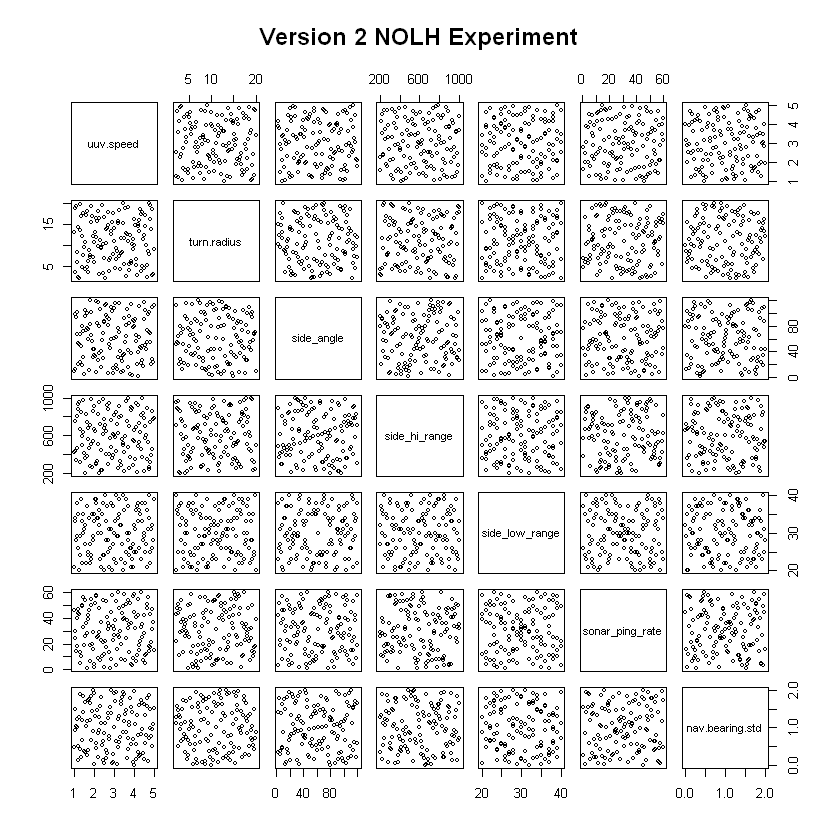

In [4]:
layout(matrix(c(1,2,3),3,1))
plot(doe.v1[c('uuv.speed','turn.radius','side_angle', 'side_hi_range','side_low_range','sonar_ping_rate', 'nav.bearing.std')], main='Version 1 NOLH Experiment', cex=0.6)
plot(doe.v2[c('uuv.speed','turn.radius','side_angle', 'side_hi_range','side_low_range','sonar_ping_rate', 'nav.bearing.std')], main='Version 2 LHS Experiment', cex=0.6)
plot(doe.v2.nolh[c('uuv.speed','turn.radius','side_angle', 'side_hi_range','side_low_range','sonar_ping_rate', 'nav.bearing.std')], main='Version 2 NOLH Experiment', cex=0.6)

### Model Differences
The `count.mine.contacts` metric is a function of the side sensor parameters in both models.  Comparing these parameters between models, the only difference is the range of the `side_angle` parameter, where both version 1 and version 2 NOLH include samples at much smaller angles than version 2.
The version 1 model can be simplified analytically to show that the probability that a mine is detected is kind of like a binomial distribution 

$\Pr(X\geq k)=1-\sum _{i=0}^{\lfloor k\rfloor }{n \choose i}p^{i}(1-p)^{n-i}$ 

where $n$ is a function of `side_angle`, `uuv.speed`, and the distance the mine is away from the UUV track, and $p$ is the probabilty of detection.  $k$ represents the number of positive returns to classify a contact, and which is a single return in the model.  This would imply that more runs with smaller `side_angle` values would increase the frequency of low mine detections.  That version 2 has a much higher frequency of low mine detections suggests the difference is the sonar detection function, not the experiment parameters.

The version 2 model implements a simplified version of the active sonar equation:
$SNR = SL-2TL-SF+TS$
where $SL$ is the active source level, $2TL$ is the round-trip dissipation of the sound intensity, $SF$ is the `signal.factor` representing aggregate ambient noise of the environment and the noise filtering ability of the sonar system, $TS$ is the target strength representing how well the target reflects the signal, and $SNR$ is the amount of signal discernable above the noise.  $2TL$ is range dependent, and defined as $20 {\log (2 \cdot d)}$ accounting for the inverse square law.  A detection is made if $SNR$ is above a threshold, which is modeled as a normal random variable to account for short-term randomness in the noise and reverberation level.  This effectively reduces the probability of detection.

### Output Metric Analysis
Looking at the output metrics for the experiments will give us a big-picture feel for how the model behaves.  We'll group the data into quintiles for each output metric: `count.mine.contacts`, `X.step`, `max.nav.error`, `marker.mean`, `marker.std.dev`, and `number.of.collisions`.

In [ ]:
library(dplyr)

In [6]:
# assign each run to a quintile along run metrics
filtered.data.v1 %>% mutate(
    mine.quintile = ntile(filtered.data.v1$count.mine.contacts, 5),
    step.quintile = ntile(filtered.data.v1$X.step, 5),
    nav.error.quintile = ntile(max.nav.error, 5),
    marker.mean.quintile = ntile(marker.mean, 5),
    marker.std.quintile = ntile(marker.std.dev, 5),
    collisions.quintile = ntile(number.of.collisions, 5)
) -> data.v1.quintiles

filtered.data.v2 %>% mutate(
    mine.quintile = ntile(filtered.data.v2$count.mine.contacts, 5),
    step.quintile = ntile(filtered.data.v2$X.step, 5),
    nav.error.quintile = ntile(max.nav.error, 5),
    marker.mean.quintile = ntile(marker.mean, 5),
    marker.std.quintile = ntile(marker.std.dev, 5),
    collisions.quintile = ntile(number.of.collisions, 5)
) -> data.v2.quintiles

filtered.data.v2.nolh %>% mutate(
    mine.quintile = ntile(filtered.data.v2.nolh$count.mine.contacts, 5),
    step.quintile = ntile(filtered.data.v2.nolh$X.step, 5),
    nav.error.quintile = ntile(max.nav.error, 5),
    marker.mean.quintile = ntile(marker.mean, 5),
    marker.std.quintile = ntile(marker.std.dev, 5),
    collisions.quintile = ntile(number.of.collisions, 5)
) -> data.v2.nolh.quintiles

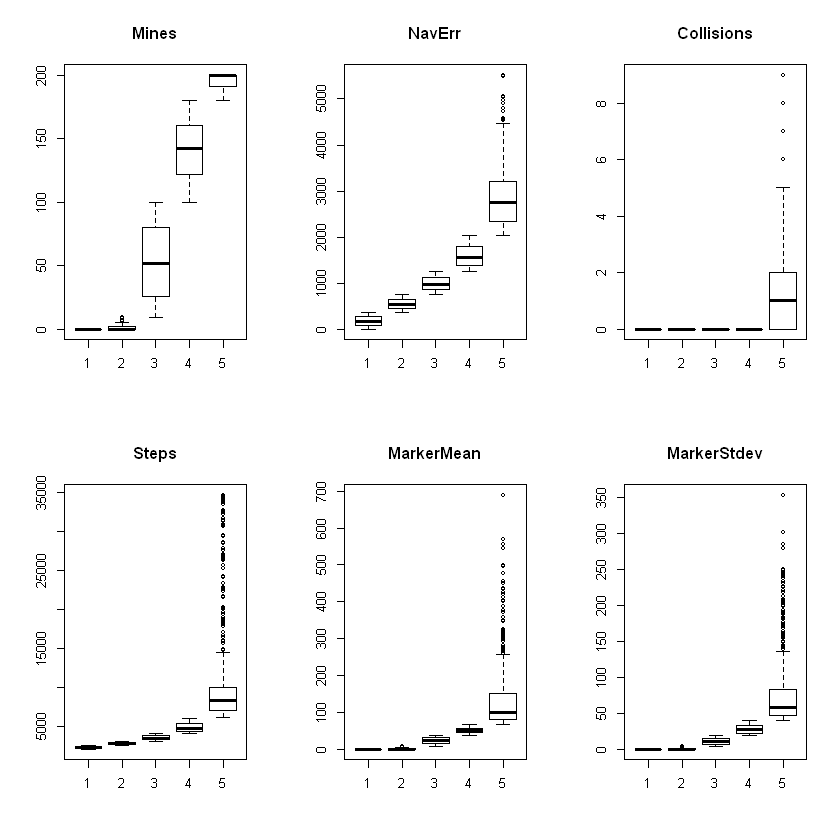

In [7]:
# plot the quintile distributions of the version 2 model
layout(matrix(c(1,2,3,4,5,6),2,3))
boxplot(count.mine.contacts~mine.quintile, data=data.v2.quintiles, main='Mines')
boxplot(X.step.~step.quintile, data=data.v2.quintiles, main='Steps')
boxplot(max.nav.error~nav.error.quintile, data=data.v2.quintiles, main='NavErr')
boxplot(marker.mean~marker.mean.quintile, data=data.v2.quintiles, main='MarkerMean')
boxplot(number.of.collisions~collisions.quintile, data=data.v2.quintiles, main='Collisions')
boxplot(marker.std.dev~marker.std.quintile, data=data.v2.quintiles, main='MarkerStdev')

The boxplots suggest that the experiment design surveys a region outside the normal operating parameters of the model UUV.  This is indicated by the upper quintiles that have a very large variance.  For mines, the lowest two quintiles are very compact and have very few mine detections, and the upper quintile is also more compact.  There is a sharp cutoff in the version 2 model, compared to a more linear response in the version 1 model (below).  This could indicate that the version 2 model experiments don't represent (or vary) a factor that the more traditional probability of detect model handles.

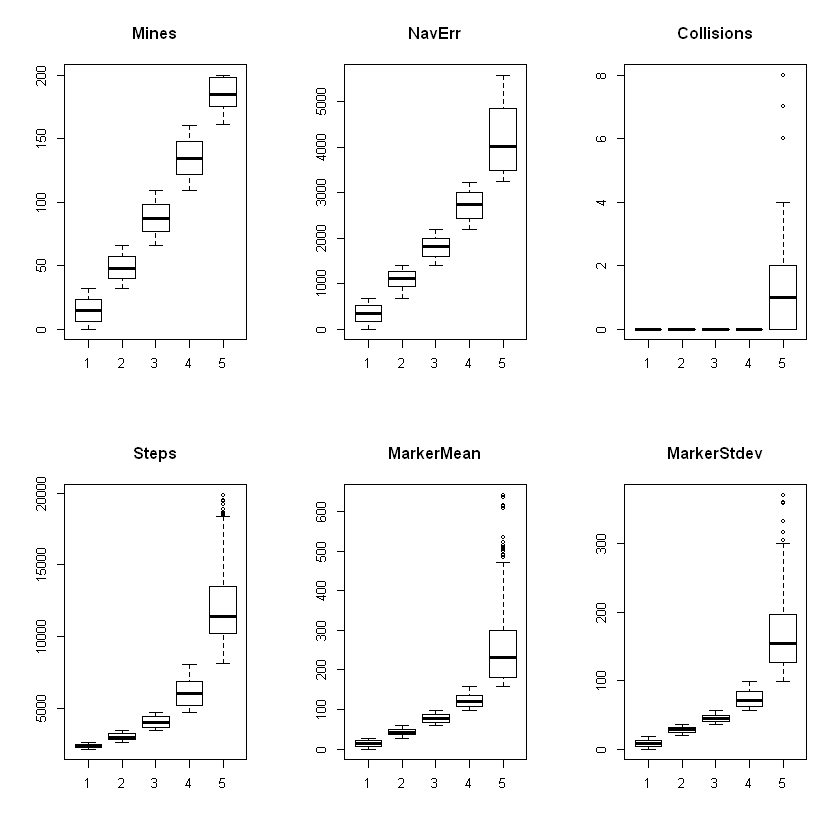

In [8]:
# plot the quintile distributions of the version 1 model
layout(matrix(c(1,2,3,4,5,6),2,3))
boxplot(count.mine.contacts~mine.quintile, data=data.v1.quintiles, main='Mines')
boxplot(X.step.~step.quintile, data=data.v1.quintiles, main='Steps')
boxplot(max.nav.error~nav.error.quintile, data=data.v1.quintiles, main='NavErr')
boxplot(marker.mean~marker.mean.quintile, data=data.v1.quintiles, main='MarkerMean')
boxplot(number.of.collisions~collisions.quintile, data=data.v1.quintiles, main='Collisions')
boxplot(marker.std.dev~marker.std.quintile, data=data.v1.quintiles, main='MarkerStdev')

# Analyzing Vulnerabilities

## Correlation Analysis
We'll start by looking at the correlation matrix of the experiments.  We can use the correlation plots to look for causal relationships between simulation parameters to outputs.

In [ ]:
library(Hmisc)
library(corrplot)

In [10]:
# compute correlation matrices
cor.v1 <- rcorr(as.matrix(filtered.data.v1[c(2:16,24:28)]))
cor.v2 <- rcorr(as.matrix(filtered.data.v2[c(2:16,18:23)]))
cor.v2.nolh <- rcorr(as.matrix(filtered.data.v2.nolh[c(2:16,18:23)]))

### Version 1 Correlation

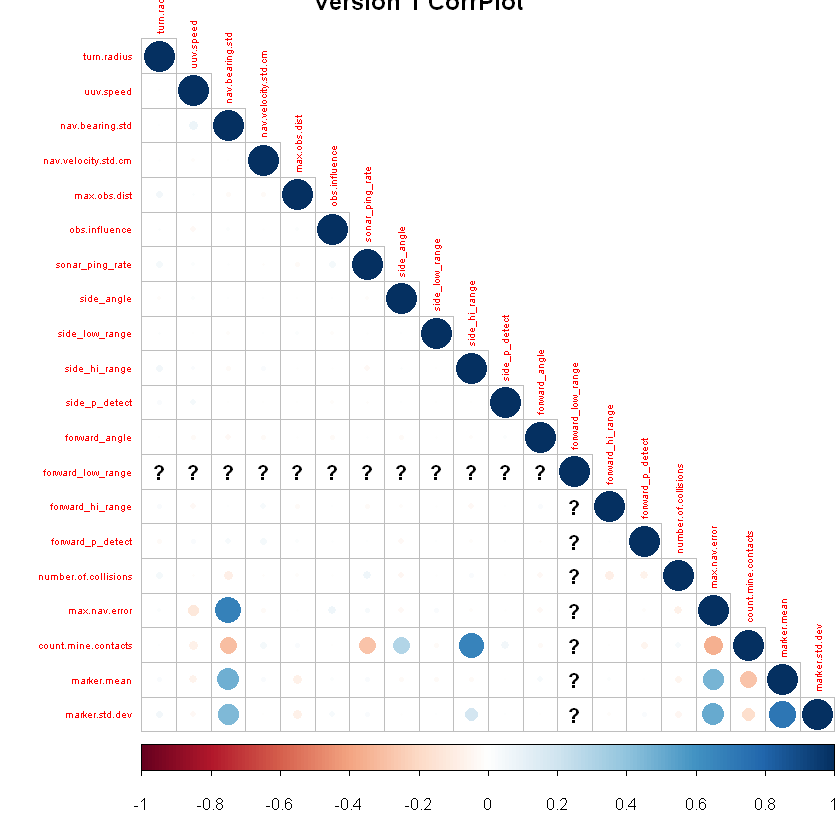

In [37]:
corrplot(cor.v1$r, main="Version 1 CorrPlot", type="lower", tl.cex=0.5)

The version 1 correlation plot shows the importance of `nav.bearing.std` on the position error metrics.  It also has some correlation with `count.mine.contacts`, which is expected because this can drive the UUV out of range.  The `count.mine.contacts` metric is strongly correlated with the `side_hi_range` parameter and somewhat correlated with `side_angle`, but it is interesting to note that there is not much correlation with `side_p_detect`.  Taking note that there is also negative correlation between `sonar_ping_rate` and `count.mine.contacts`, this could be described by the binomial-like probability where the number of trials (pings) is so large that the probability of getting at least one positive return is high even for low probabilities of detection.

### Version 2 Correlation

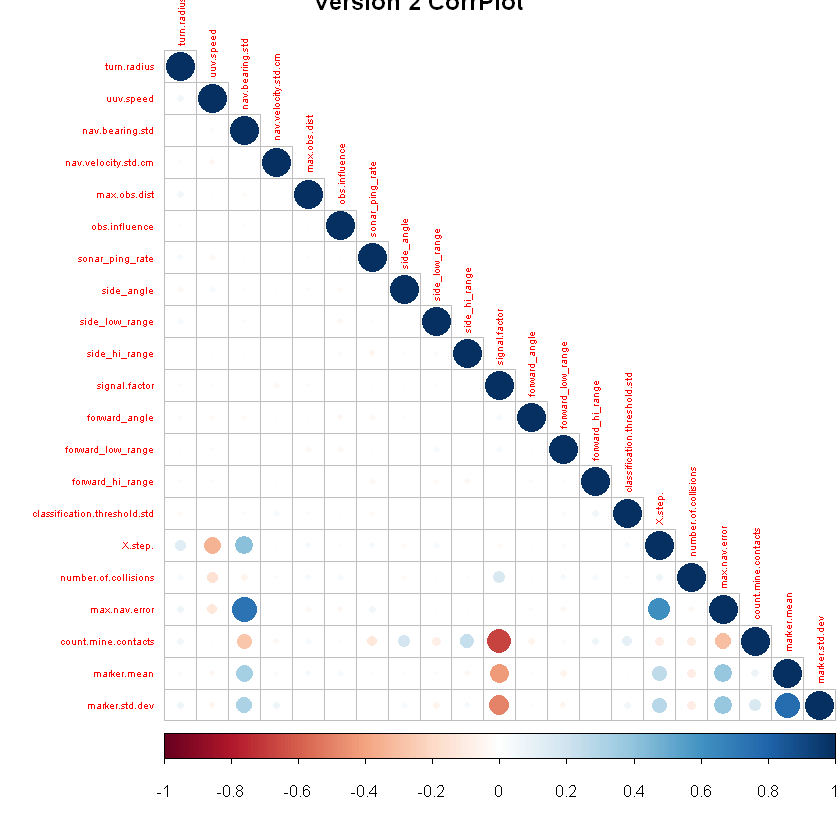

In [92]:
corrplot(cor.v2.nolh$r, main="Version 2 CorrPlot", type="lower", tl.cex=0.5)

The version 2 model shows a the same expected correlation between the `nav.bearing.std` and navigation error metrics.  Also note that in both version 1 and version 2 models, the `nav.velocity.std.cm` parameter doesn't have much impact on any of the metrics.  This suggests that the heading or moment error is much more impactful than the linear velocity error.

In the version 2 model, `signal.factor` has a very high correlation with `count.mine.contacts`.  This should be expected because mine detection is a function of $SNR$ in the model.  The side sensor parameters also correlate to mine detection as expected.

## Principal Component Analysis
A prinicipal comonent analysis (PCA) of the simulation results can identify how parameters contribute to the variance in the overall dataset.  This helps focus the scope of the vulnerability analysis.

The first analysis will look at the entire dataset, including factors and metrics.  The goal of this analysis is to identify where metrics and factors are aligned in each component.  Components dominated by a metric, such as `count.mine.contacts`, should have one or more input factors contributing to the component as well.  Because we have the advantage of knowing causality (i.e. we designed the factors in the experiment) we can infer that the variance in the data resulting from the metric is caused by the factors along that component axis.


Reference: Chapter 12 of
Rencher, Alvin C., and Christensen, William F.. 2012. Methods of Multivariate Analysis. Somerset: John Wiley & Sons, Incorporated. Accessed January 20, 2019. ProQuest Ebook Central.

In [96]:
library(ggfortify)  # load the graphics library for PCA visualization

Importance of components:
                          PC1    PC2    PC3     PC4    PC5     PC6     PC7
Standard deviation     1.6102 1.5428 1.2313 1.15616 1.0903 1.06927 1.06510
Proportion of Variance 0.1235 0.1134 0.0722 0.06365 0.0566 0.05445 0.05402
Cumulative Proportion  0.1235 0.2368 0.3090 0.37267 0.4293 0.48372 0.53774
                           PC8     PC9    PC10    PC11    PC12    PC13    PC14
Standard deviation     1.03628 1.00515 0.98763 0.94664 0.93254 0.91895 0.90251
Proportion of Variance 0.05114 0.04811 0.04645 0.04267 0.04141 0.04021 0.03879
Cumulative Proportion  0.58887 0.63698 0.68343 0.72611 0.76752 0.80773 0.84652
                          PC15   PC16    PC17    PC18   PC19   PC20    PC21
Standard deviation     0.87283 0.8337 0.79826 0.68916 0.5205 0.4935 0.37362
Proportion of Variance 0.03628 0.0331 0.03034 0.02262 0.0129 0.0116 0.00665
Cumulative Proportion  0.88279 0.9159 0.94624 0.96885 0.9818 0.9933 1.00000

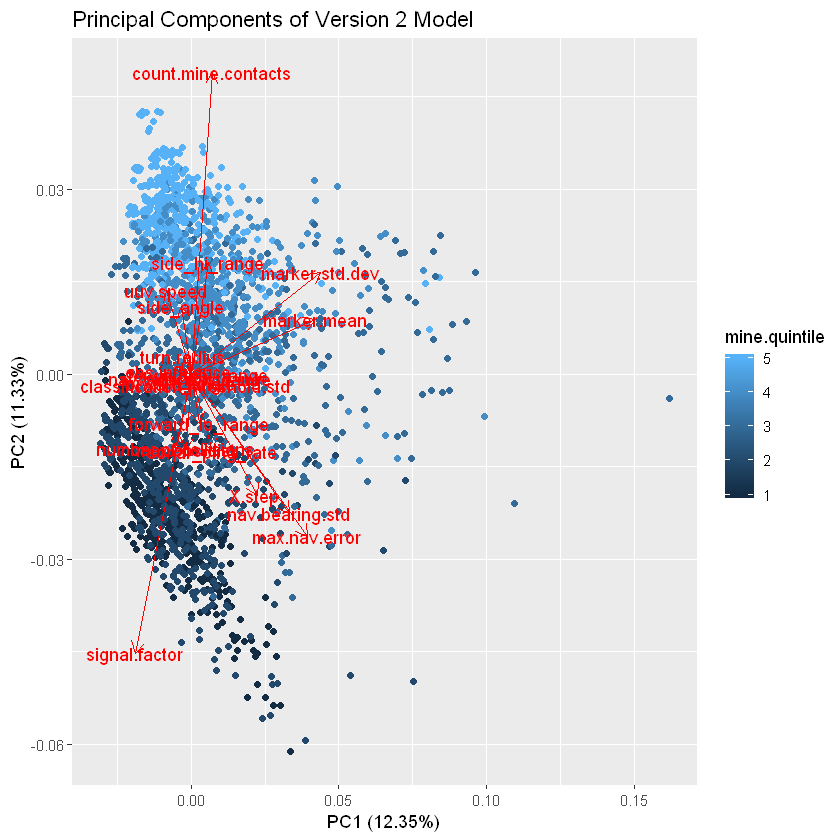

In [22]:
# PCA of input and output metrics
filtered.data.v2.pca <- prcomp(filtered.data.v2[c(2:16,18:23)], scale=TRUE)
summary(filtered.data.v2.pca)
autoplot(filtered.data.v2.pca, data=data.v2.quintiles, colour='mine.quintile', main="Principal Components of Version 2 Model", loadings=TRUE, loadings.label=TRUE)

The results above show the runs plotted on first two principal components, making up a total of 23.5% of the variance within the scaled and normalized simulation results.  Clearly, `count.mine.contacts`,  `signal.factor`, and `nav.bearing.std` contribute significantly to the second component, while the first component is dominated by navigation error-related `marker.std.dev`, `marker.mean`, `max.nav.error`, and `nav.bearing.std`.

The NOLH experiment has similar components, although the first component is flipped.

Importance of components:
                          PC1    PC2    PC3     PC4     PC5     PC6     PC7
Standard deviation     1.7178 1.4765 1.1429 1.05772 1.05253 1.04002 1.03372
Proportion of Variance 0.1405 0.1038 0.0622 0.05327 0.05275 0.05151 0.05088
Cumulative Proportion  0.1405 0.2443 0.3065 0.35979 0.41255 0.46405 0.51494
                           PC8     PC9    PC10    PC11    PC12    PC13    PC14
Standard deviation     1.02408 1.01451 1.01113 0.98569 0.96981 0.96502 0.96309
Proportion of Variance 0.04994 0.04901 0.04868 0.04627 0.04479 0.04435 0.04417
Cumulative Proportion  0.56488 0.61389 0.66257 0.70884 0.75363 0.79797 0.84214
                          PC15    PC16   PC17    PC18   PC19    PC20    PC21
Standard deviation     0.92578 0.91860 0.7844 0.64899 0.4741 0.45428 0.38280
Proportion of Variance 0.04081 0.04018 0.0293 0.02006 0.0107 0.00983 0.00698
Cumulative Proportion  0.88296 0.92314 0.9524 0.97249 0.9832 0.99302 1.00000

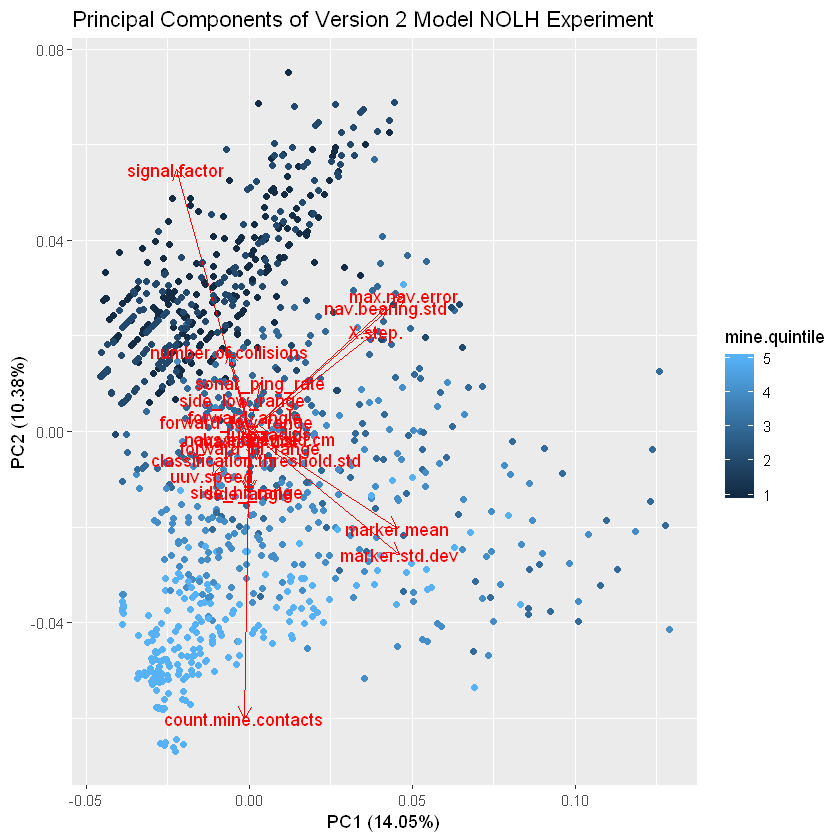

In [25]:
# PCA of input and output metrics
filtered.data.v2.nolh.pca <- prcomp(filtered.data.v2.nolh[c(2:16,18:23)], scale=TRUE)
summary(filtered.data.v2.nolh.pca)
autoplot(filtered.data.v2.nolh.pca, data=data.v2.nolh.quintiles, colour='mine.quintile', main="Principal Components of Version 2 Model NOLH Experiment", loadings=TRUE, loadings.label=TRUE)

Focusing on the first 7 components accounting for 50% of the population variation,

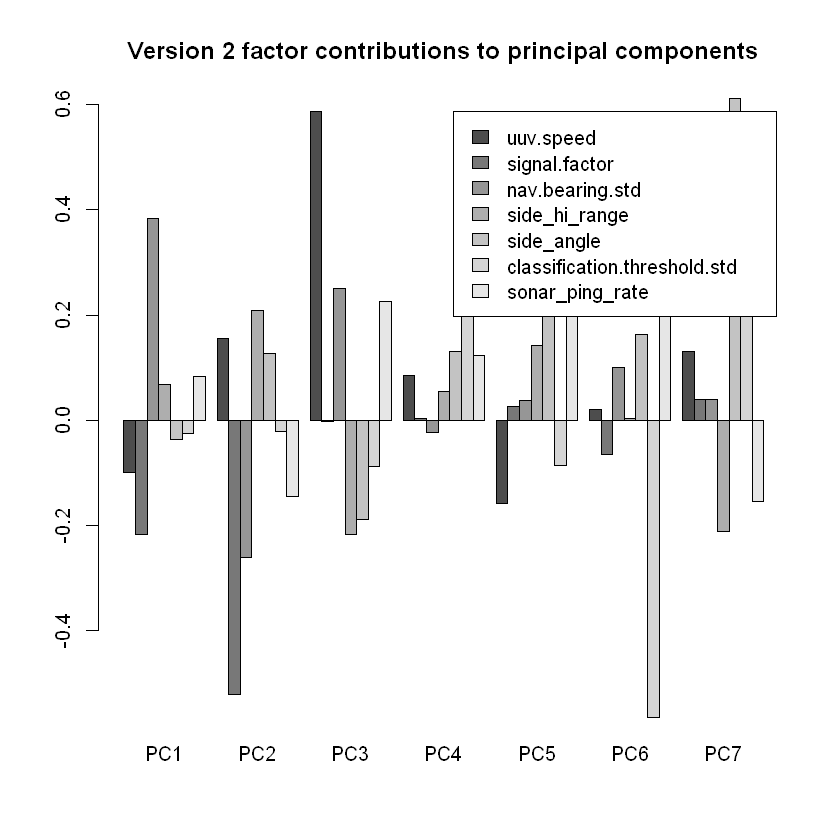

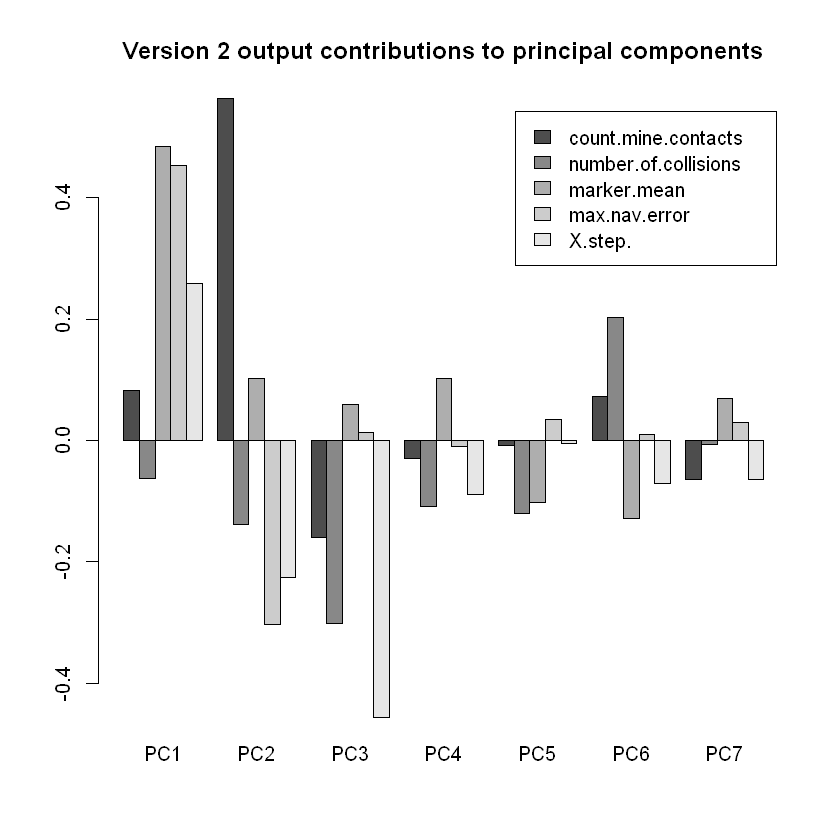

In [39]:
barplot(
    filtered.data.v2.pca$rotation[
        c(
            'uuv.speed',
            'signal.factor',
            'nav.bearing.std', 
            'side_hi_range', 
            'side_angle',
            'classification.threshold.std',
            'sonar_ping_rate'
        ),
        c(1:7)
    ], 
        legend=TRUE, beside=TRUE,
    main="Version 2 factor contributions to principal components"
)
barplot(
    filtered.data.v2.pca$rotation[
    c('count.mine.contacts','number.of.collisions','marker.mean','max.nav.error','X.step.'),
    c(1:7)],
        legend=TRUE, beside=TRUE,
    main="Version 2 output contributions to principal components"
)

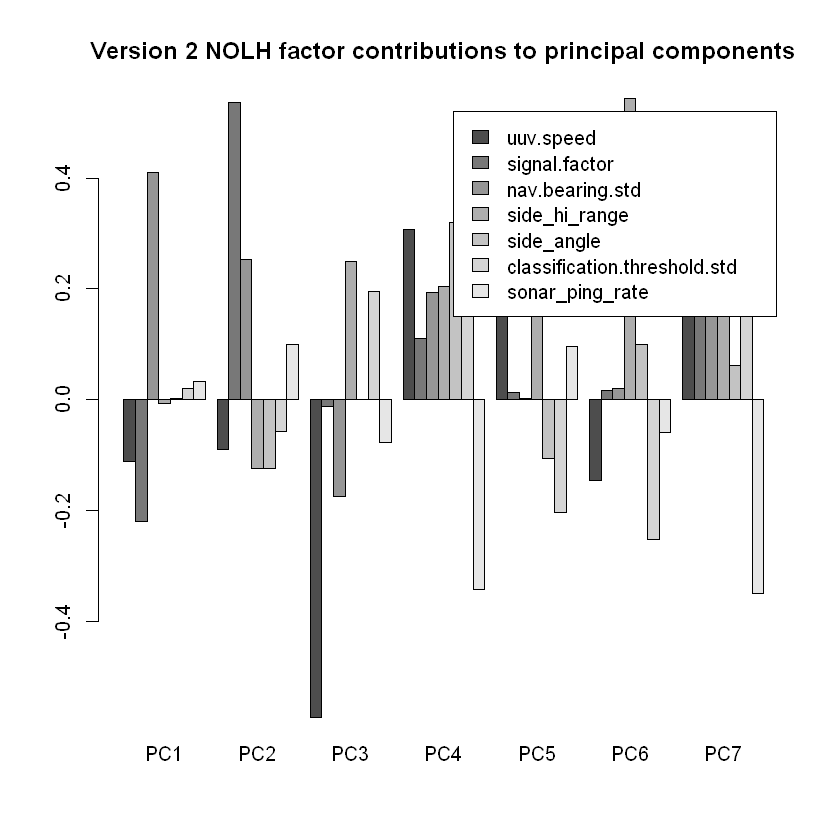

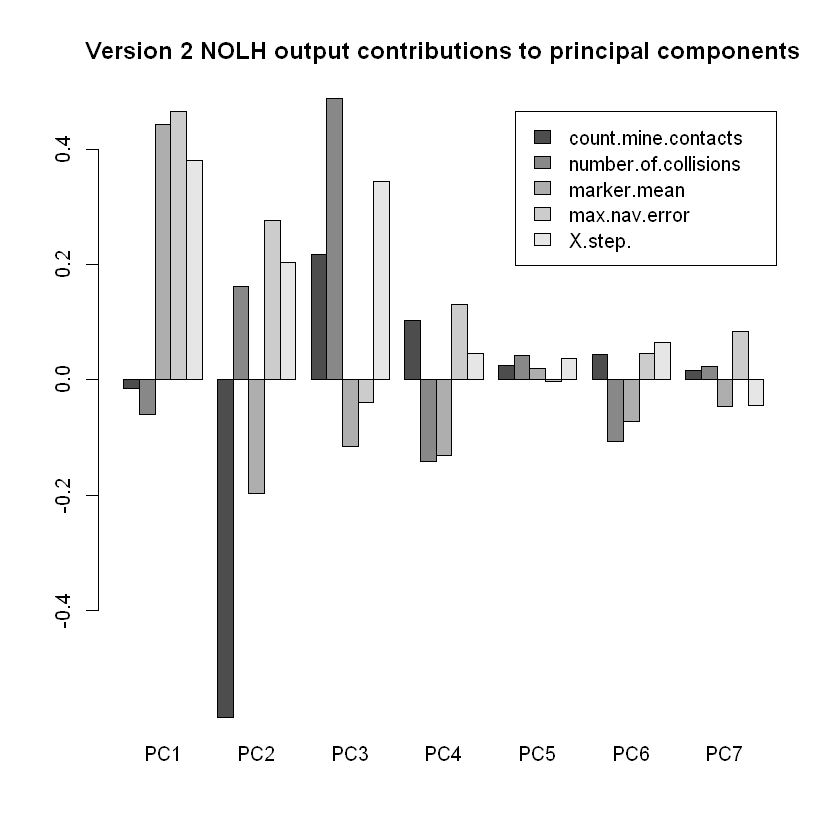

In [40]:
barplot(
    filtered.data.v2.nolh.pca$rotation[
        c(
            'uuv.speed',
            'signal.factor',
            'nav.bearing.std', 
            'side_hi_range', 
            'side_angle',
            'classification.threshold.std',
            'sonar_ping_rate'
        ),
        c(1:7)
    ], 
        legend=TRUE, beside=TRUE,
    main="Version 2 NOLH factor contributions to principal components"
)
barplot(
    filtered.data.v2.nolh.pca$rotation[
    c('count.mine.contacts','number.of.collisions','marker.mean','max.nav.error','X.step.'),
    c(1:7)],
        legend=TRUE, beside=TRUE,
    main="Version 2 NOLH output contributions to principal components"
)

## Variable Analysis
Using what we've found through correlation analysis and PCA, we can isolate the more important variables to build some statistical models of the metrics.

In [132]:
mine.detection.model.v2 <- count.mine.contacts ~ (
    signal.factor + nav.bearing.std + side_hi_range + sonar_ping_rate
)
    
nav.model.v2 <- max.nav.error ~ (
    nav.bearing.std + nav.velocity.std.cm + uuv.speed
)

### Partition Tree Analysis


In [116]:
library(maptree)

Call:
rpart(formula = mine.detection.model.v2, data = filtered.data.v2, 
    method = "anova")
  n= 2625 

          CP nsplit rel error    xerror        xstd
1 0.72343093      0 1.0000000 1.0010321 0.013452909
2 0.05887020      1 0.2765691 0.2776392 0.010050991
3 0.02992915      2 0.2176989 0.2200815 0.008699164
4 0.02841066      3 0.1877697 0.1933575 0.007697079
5 0.01000000      4 0.1593591 0.1633161 0.006654533

Variable importance
  signal.factor   side_hi_range sonar_ping_rate nav.bearing.std 
             69              14               9               8 

Node number 1: 2625 observations,    complexity param=0.7234309
  mean=78.17486, MSE=6362.217 
  left son=2 (1330 obs) right son=3 (1295 obs)
  Primary splits:
      signal.factor   < 43.79317  to the right, improve=0.72343090, (0 missing)
      side_hi_range   < 525.8124  to the left,  improve=0.07669057, (0 missing)
      nav.bearing.std < 0.3809098 to the right, improve=0.05311211, (0 missing)
      sonar_ping_rate < 15.82

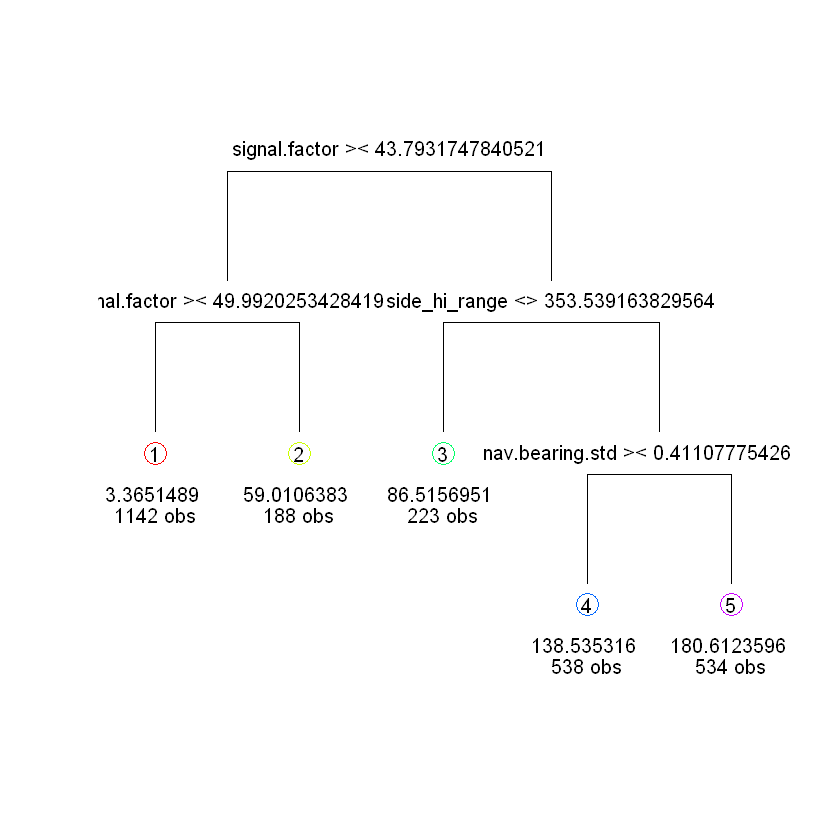

In [130]:
mine.detection.v2.tree <- rpart(mine.detection.model.v2, method='anova', data=filtered.data.v2)
summary(mine.detection.v2.tree)
draw.tree(mine.detection.v2.tree)

Call:
rpart(formula = nav.model.v2, data = filtered.data.v2, method = "anova")
  n= 2625 

          CP nsplit rel error    xerror       xstd
1 0.34069127      0 1.0000000 1.0004848 0.03266479
2 0.04918347      1 0.6593087 0.6638397 0.02340279
3 0.03969873      2 0.6101253 0.6144949 0.02270479
4 0.02318292      3 0.5704265 0.5825140 0.02174623
5 0.01000000      4 0.5472436 0.5614466 0.02093332

Variable importance
    nav.bearing.std nav.velocity.std.cm           uuv.speed 
                 84                   8                   8 

Node number 1: 2625 observations,    complexity param=0.3406913
  mean=1236.069, MSE=984775 
  left son=2 (1275 obs) right son=3 (1350 obs)
  Primary splits:
      nav.bearing.std     < 0.4324351  to the left,  improve=0.340691300, (0 missing)
      uuv.speed           < 2.013619   to the right, improve=0.040731640, (0 missing)
      nav.velocity.std.cm < 0.01240088 to the right, improve=0.009596823, (0 missing)
  Surrogate splits:
      nav.velocity.std.

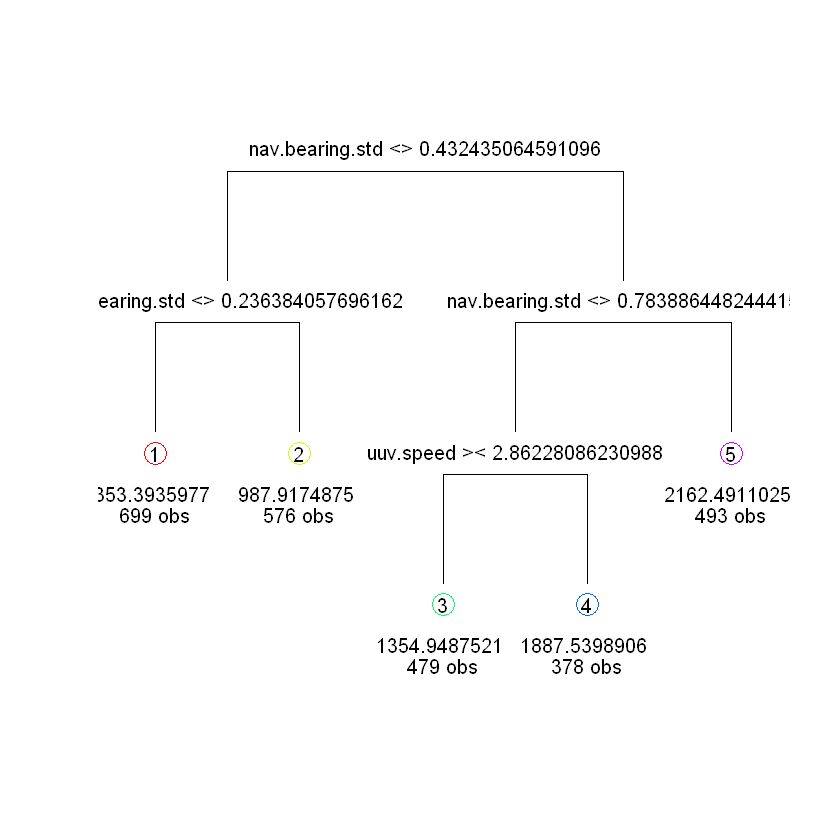

In [133]:
nav.error.v2.tree <- rpart(nav.model.v2, method='anova', data=filtered.data.v2)
summary(nav.error.v2.tree)
draw.tree(nav.error.v2.tree)

In [128]:
summary(lm(mine.detection.model.v2, data=filtered.data.v2))


Call:
lm(formula = mine.detection.model.v2, data = filtered.data.v2)

Residuals:
     Min       1Q   Median       3Q      Max 
-131.060  -30.084   -1.226   29.873  115.611 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)     182.17071    3.47412   52.44   <2e-16 ***
signal.factor    -2.35344    0.03243  -72.57   <2e-16 ***
nav.bearing.std -40.64836    2.95111  -13.77   <2e-16 ***
side_hi_range     0.06256    0.00361   17.33   <2e-16 ***
sonar_ping_rate  -1.10214    0.09700  -11.36   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 42.64 on 2620 degrees of freedom
Multiple R-squared:  0.7148,	Adjusted R-squared:  0.7144 
F-statistic:  1642 on 4 and 2620 DF,  p-value: < 2.2e-16


### Mine detection related to signal factor
The boxplots below show a clear negative correlation between the `signal.factor` and mine detection.

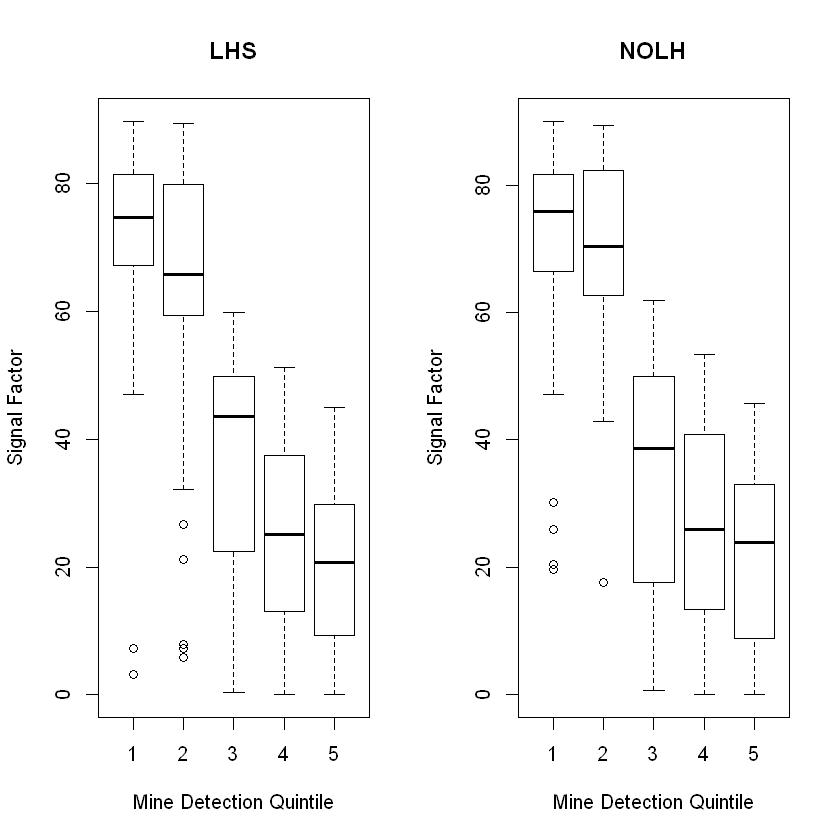

In [93]:
layout(matrix(c(1,2),1,2))
boxplot(signal.factor~mine.quintile, data=data.v2.quintiles, main="LHS", xlab="Mine Detection Quintile", ylab="Signal Factor")
boxplot(signal.factor~mine.quintile, data=data.v2.nolh.quintiles, main="NOLH", xlab="Mine Detection Quintile", ylab="Signal Factor")

In [134]:
mines.model <- count.mine.contacts ~ .
# linear regression to fit factors to count.mine.contacts
fit.mines.v1 <- lm(mines.model, data=filtered.data.v1[c(2:16,26)])
fit.mines.v2 <- lm(mines.model, data=filtered.data.v2[c(2:16,21)])
fit.mines.v2.nolh <- lm(mines.model, data=filtered.data.v2.nolh[c(2:16,21)])
summary(fit.mines.v1)
summary(fit.mines.v2)
summary(fit.mines.v2.nolh)


Call:
lm(formula = mines.model, data = filtered.data.v1[c(2:16, 26)])

Residuals:
     Min       1Q   Median       3Q      Max 
-132.825  -23.123    2.413   22.373  104.395 

Coefficients: (1 not defined because of singularities)
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)          19.590878  11.046470   1.773 0.076435 .  
turn.radius          -0.203057   0.207392  -0.979 0.327758    
uuv.speed            -3.917794   0.963070  -4.068  5.1e-05 ***
nav.bearing.std     -29.200233   1.804533 -16.182  < 2e-16 ***
nav.velocity.std.cm   2.614517   1.782182   1.467 0.142666    
max.obs.dist          0.145953   0.126821   1.151 0.250053    
obs.influence         0.879556   0.828384   1.062 0.288582    
sonar_ping_rate      -0.897522   0.061839 -14.514  < 2e-16 ***
side_angle            0.514901   0.030567  16.845  < 2e-16 ***
side_low_range       -0.325759   0.180769  -1.802 0.071820 .  
side_hi_range         0.170724   0.004550  37.521  < 2e-16 ***
side_p_detect


Call:
lm(formula = mines.model, data = filtered.data.v2[c(2:16, 21)])

Residuals:
     Min       1Q   Median       3Q      Max 
-127.635  -29.513   -1.066   28.812  117.178 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  168.431267   7.917406  21.274  < 2e-16 ***
turn.radius                    0.336500   0.161572   2.083  0.03738 *  
uuv.speed                     -2.326608   0.738877  -3.149  0.00166 ** 
nav.bearing.std              -38.416800   2.984637 -12.872  < 2e-16 ***
nav.velocity.std.cm           -2.210773   2.935209  -0.753  0.45140    
max.obs.dist                  -0.165679   0.101081  -1.639  0.10132    
obs.influence                  0.649600   0.651851   0.997  0.31908    
sonar_ping_rate               -1.107112   0.096650 -11.455  < 2e-16 ***
side_angle                     0.177624   0.029336   6.055 1.61e-09 ***
side_low_range                 0.356390   0.145248   2.454  0.01421 *  
side_hi_range     


Call:
lm(formula = mines.model, data = filtered.data.v2.nolh[c(2:16, 
    21)])

Residuals:
     Min       1Q   Median       3Q      Max 
-107.476  -31.433    0.642   24.743  107.571 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  131.867450  11.412816  11.554  < 2e-16 ***
turn.radius                    0.648962   0.247200   2.625 0.008791 ** 
uuv.speed                      1.067200   1.096911   0.973 0.330832    
nav.bearing.std              -31.951212   2.071463 -15.424  < 2e-16 ***
nav.velocity.std.cm           -7.819635   2.082205  -3.755 0.000183 ***
max.obs.dist                   0.273744   0.150579   1.818 0.069373 .  
obs.influence                 -1.755907   0.955641  -1.837 0.066446 .  
sonar_ping_rate               -0.408200   0.070723  -5.772 1.05e-08 ***
side_angle                     0.326768   0.035435   9.222  < 2e-16 ***
side_low_range                -1.080896   0.210611  -5.132 3.44e-07 ***
side_hi_

In [135]:
collisions.model <- number.of.collisions ~ .
fit.collisions.v1 <- lm(collisions.model, data=filtered.data.v1[c(2:16, 24)])
fit.collisions.v2 <- lm(collisions.model, data=filtered.data.v2[c(2:16,19)])
fit.collisions.v2.nolh <- lm(collisions.model, data=filtered.data.v2.nolh[c(2:16,19)])
summary(fit.collisions.v1)
summary(fit.collisions.v2)
summary(fit.collisions.v2.nolh)


Call:
lm(formula = collisions.model, data = filtered.data.v1[c(2:16, 
    24)])

Residuals:
    Min      1Q  Median      3Q     Max 
-0.4476 -0.2324 -0.1567 -0.0527  7.7098 

Coefficients: (1 not defined because of singularities)
                      Estimate Std. Error t value Pr(>|t|)   
(Intercept)          5.303e-01  2.000e-01   2.651  0.00814 **
turn.radius          5.901e-03  3.755e-03   1.571  0.11641   
uuv.speed           -3.922e-03  1.744e-02  -0.225  0.82212   
nav.bearing.std     -8.753e-02  3.268e-02  -2.679  0.00751 **
nav.velocity.std.cm -8.489e-03  3.227e-02  -0.263  0.79256   
max.obs.dist        -1.721e-03  2.296e-03  -0.749  0.45387   
obs.influence       -5.204e-03  1.500e-02  -0.347  0.72872   
sonar_ping_rate      2.196e-03  1.120e-03   1.961  0.05016 . 
side_angle          -8.235e-04  5.535e-04  -1.488  0.13709   
side_low_range      -9.210e-04  3.273e-03  -0.281  0.77849   
side_hi_range        3.947e-05  8.239e-05   0.479  0.63205   
side_p_detect       -2.06


Call:
lm(formula = collisions.model, data = filtered.data.v2[c(2:16, 
    19)])

Residuals:
    Min      1Q  Median      3Q     Max 
-0.7735 -0.3746 -0.2155 -0.0393  8.5431 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                   7.453e-01  1.573e-01   4.739 2.26e-06 ***
turn.radius                   9.961e-03  3.209e-03   3.104  0.00193 ** 
uuv.speed                    -1.202e-01  1.468e-02  -8.190 4.04e-16 ***
nav.bearing.std              -1.193e-01  5.928e-02  -2.013  0.04425 *  
nav.velocity.std.cm          -1.000e-01  5.830e-02  -1.716  0.08634 .  
max.obs.dist                 -3.947e-04  2.008e-03  -0.197  0.84418    
obs.influence                -3.635e-02  1.295e-02  -2.808  0.00503 ** 
sonar_ping_rate               1.519e-03  1.920e-03   0.791  0.42890    
side_angle                   -1.202e-04  5.827e-04  -0.206  0.83664    
side_low_range               -6.433e-03  2.885e-03  -2.230  0.02584 *  
side_hi_range     


Call:
lm(formula = collisions.model, data = filtered.data.v2.nolh[c(2:16, 
    19)])

Residuals:
    Min      1Q  Median      3Q     Max 
-0.6248 -0.3401 -0.1951  0.0138  6.6235 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                   1.049e-01  2.256e-01   0.465    0.642    
turn.radius                   7.177e-03  4.887e-03   1.469    0.142    
uuv.speed                    -1.135e-01  2.169e-02  -5.236 2.00e-07 ***
nav.bearing.std              -6.534e-02  4.095e-02  -1.596    0.111    
nav.velocity.std.cm          -2.833e-02  4.117e-02  -0.688    0.492    
max.obs.dist                  3.334e-03  2.977e-03   1.120    0.263    
obs.influence                 2.232e-02  1.889e-02   1.181    0.238    
sonar_ping_rate              -3.521e-04  1.398e-03  -0.252    0.801    
side_angle                   -4.502e-04  7.006e-04  -0.643    0.521    
side_low_range                8.665e-04  4.164e-03   0.208    0.835    
side_hi_range

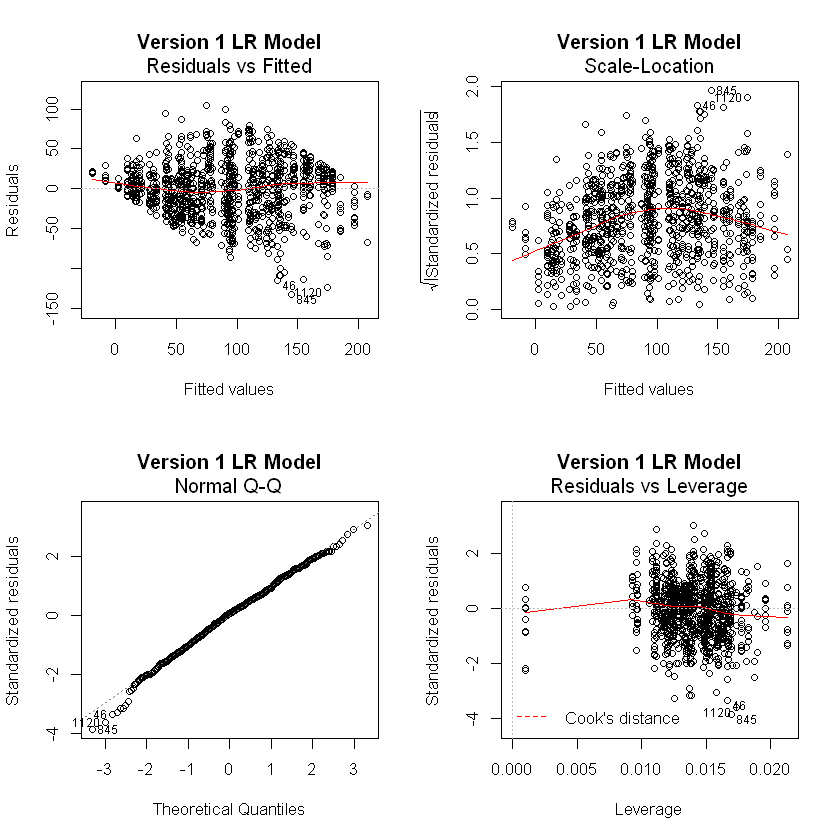

In [136]:
layout(matrix(c(1,2,3,4),2,2))
plot(fit.mines.v1, main='Version 1 LR Model')

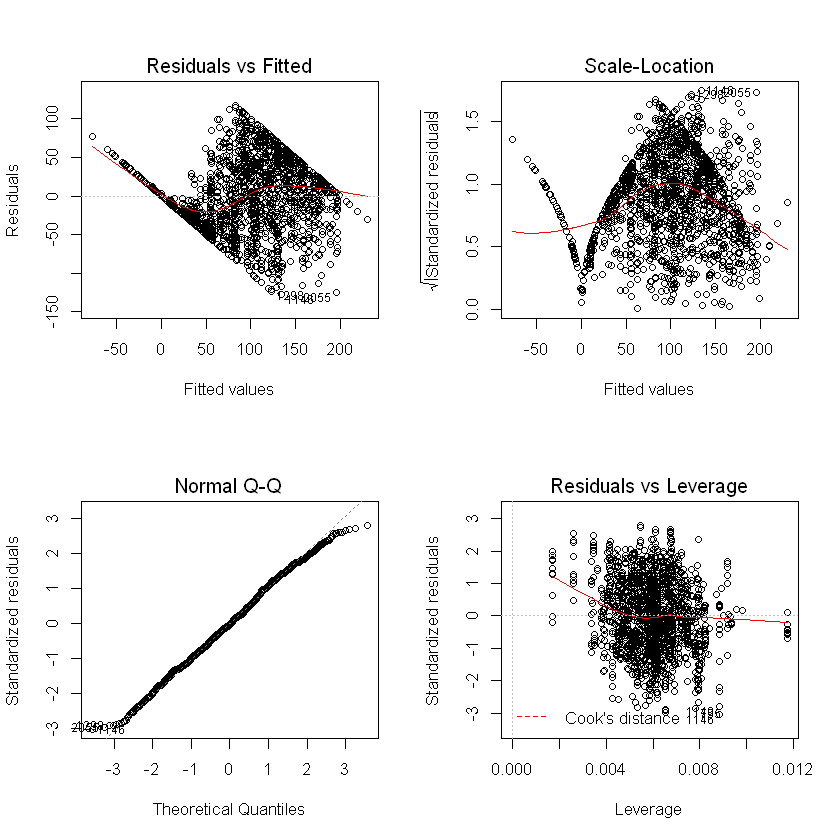

In [137]:
layout(matrix(c(1,2,3,4),2,2))
plot(fit.mines.v2)

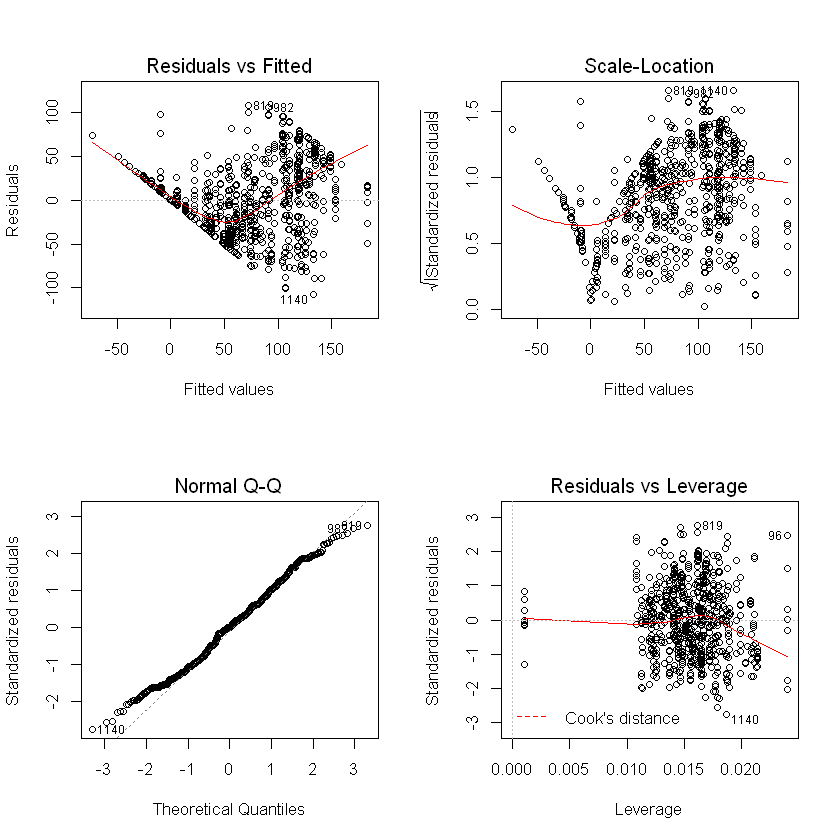

In [138]:
layout(matrix(c(1,2,3,4),2,2))
plot(fit.mines.v2.nolh)

The residual plots suggest that the mine detection models may have been over fitted.  Since the general model analysis suggests that the `count.mine.contacts` metric is primarily a function of side looking sonar parameters, we can refine the linear model.

In [13]:
refined.mine.model.v1 <- count.mine.contacts ~ (
    side_p_detect + 
    side_angle + 
    side_hi_range + 
    uuv.speed + 
    nav.bearing.std
)


Call:
lm(formula = refined.mine.model.v1, data = filtered.data.v1[c(2:16, 
    26)])

Residuals:
     Min       1Q   Median       3Q      Max 
-146.538  -25.962   -0.478   22.777  128.451 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)     -18.494359   7.823187  -2.364  0.01826 *  
side_p_detect    25.643033   7.984344   3.212  0.00136 ** 
side_angle        0.523172   0.033497  15.618  < 2e-16 ***
side_hi_range     0.173232   0.004976  34.816  < 2e-16 ***
uuv.speed        -4.257779   1.054353  -4.038 5.77e-05 ***
nav.bearing.std -29.339243   1.975986 -14.848  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 38.01 on 1062 degrees of freedom
Multiple R-squared:  0.6222,	Adjusted R-squared:  0.6204 
F-statistic: 349.8 on 5 and 1062 DF,  p-value: < 2.2e-16


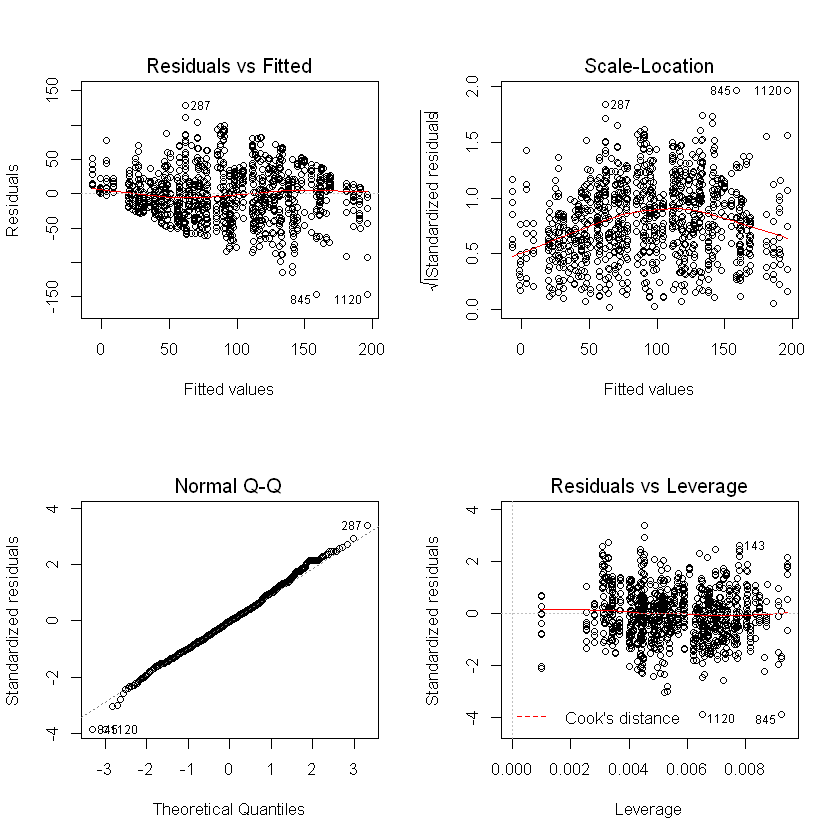

In [14]:
refined.fit.mines.v1 <- lm(refined.mine.model.v1, data=filtered.data.v1[c(2:16,26)])
summary(refined.fit.mines.v1)
layout(matrix(c(1,2,3,4),2,2))
plot(refined.fit.mines.v1)

In [15]:
refined.mine.model.v2 <- count.mine.contacts ~ (
    side_angle +
    side_hi_range +
    uuv.speed +
    nav.bearing.std +
    signal.factor +
    classification.threshold.std +
    signal.factor:classification.threshold.std
)


Call:
lm(formula = refined.mine.model.v2, data = filtered.data.v2[c(2:16, 
    21)])

Residuals:
     Min       1Q   Median       3Q      Max 
-138.744  -31.085   -0.059   29.230  121.421 

Coefficients:
                                             Estimate Std. Error t value
(Intercept)                                152.404381   5.459238  27.917
side_angle                                   0.177978   0.029266   6.081
side_hi_range                                0.065298   0.003652  17.880
uuv.speed                                   -2.659834   0.748957  -3.551
nav.bearing.std                            -42.975697   2.982733 -14.408
signal.factor                               -2.122203   0.062891 -33.744
classification.threshold.std                 1.644750   0.594492   2.767
signal.factor:classification.threshold.std  -0.049869   0.011436  -4.361
                                           Pr(>|t|)    
(Intercept)                                 < 2e-16 ***
side_angle                

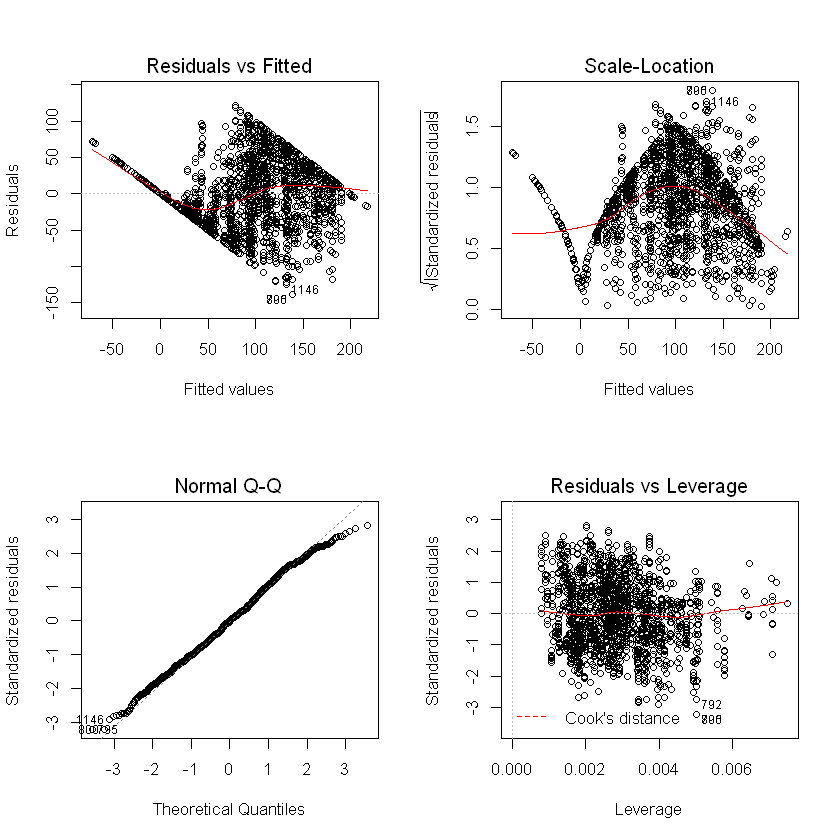

In [18]:
refined.fit.mines.v2 <- lm(refined.mine.model.v2, data=filtered.data.v2[c(2:16,21)])
summary(refined.fit.mines.v2)
layout(matrix(c(1,2,3,4),2,2))
plot(refined.fit.mines.v2)


Call:
lm(formula = refined.mine.model.v2, data = filtered.data.v2.nolh[c(2:16, 
    21)])

Residuals:
    Min      1Q  Median      3Q     Max 
-99.723 -33.083   0.223  25.708 121.732 

Coefficients:
                                             Estimate Std. Error t value
(Intercept)                                 75.690970   7.994760   9.468
side_angle                                   0.322644   0.036987   8.723
side_hi_range                                0.069507   0.005651  12.301
uuv.speed                                    1.688297   1.142012   1.478
nav.bearing.std                            -31.763099   2.162638 -14.687
signal.factor                               -1.528719   0.110219 -13.870
classification.threshold.std                 4.595392   0.996496   4.612
signal.factor:classification.threshold.std  -0.043685   0.019489  -2.242
                                           Pr(>|t|)    
(Intercept)                                 < 2e-16 ***
side_angle                     

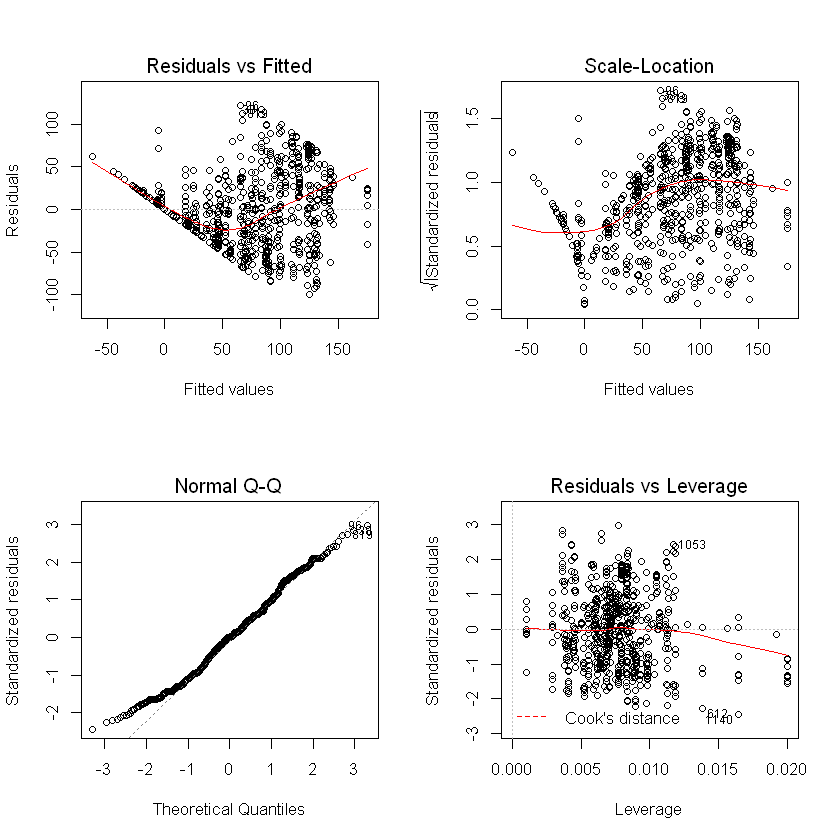

In [19]:
refined.fit.mines.v2.nolh <- lm(refined.mine.model.v2, data=filtered.data.v2.nolh[c(2:16,21)])
summary(refined.fit.mines.v2.nolh)
layout(matrix(c(1,2,3,4),2,2))
plot(refined.fit.mines.v2.nolh)

### Regression Tree

In [35]:
colnames(filtered.data.v2)

[1] "experiment.number"            "turn.radius"                 
 [3] "uuv.speed"                    "nav.bearing.std"             
 [5] "nav.velocity.std.cm"          "max.obs.dist"                
 [7] "obs.influence"                "sonar_ping_rate"             
 [9] "side_angle"                   "side_low_range"              
[11] "side_hi_range"                "signal.factor"               
[13] "forward_angle"                "forward_lo_range"            
[15] "forward_hi_range"             "classification.threshold.std"
[17] "X.run.number."                "X.step."                     
[19] "number.of.collisions"         "max.nav.error"               
[21] "count.mine.contacts"          "marker.mean"                 
[23] "marker.std.dev"